In [2]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from signal_utils_1D import *
from plot_utils_1D import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate a fixed delta function input signal

Text(0.5, 1.0, 'output signal')

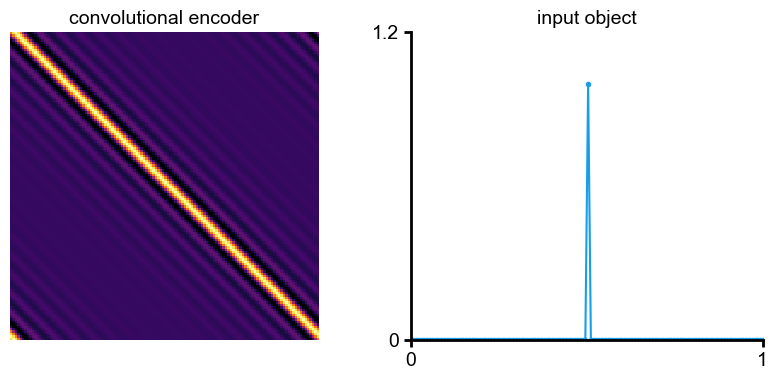

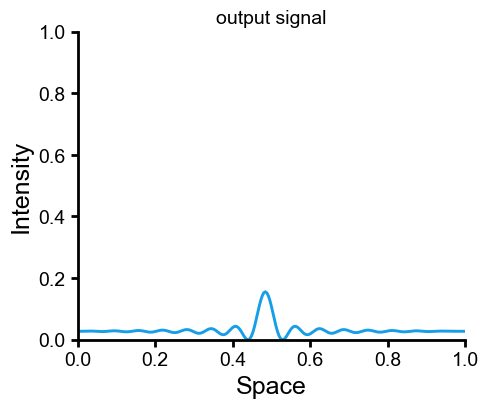

In [26]:
# signal = generate_random_1_over_f_signal(num_non_dc_in_bandlimit= 10)
delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
input_signal = delta_function
# input_signal = bandlimited_nonnegative_signal(delta_function)


# generate the convolutional encoder
nyquist_samples = onp.zeros(NUM_NYQUIST_SAMPLES)
nyquist_samples[-1] = 1
kernel = bandlimited_nonnegative_signal(nyquist_samples=np.array(nyquist_samples))

conv_mat = make_convolutional_encoder(kernel)
conv_mat_for_display = make_convolutional_encoder(kernel, sample=False)

# plot the input signal
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(conv_mat_for_display, cmap='inferno', interpolation='none')
ax[0].set_title('convolutional encoder')
# remove axes
ax[0].axis('off')


ax[1].plot(np.linspace(0,1, input_signal.size), input_signal,  '.-', label='input signal',)
ax[1].set_title('input object')
ax[1].set(xlim=(0,1))
default_format(ax[1])


# do the convolution
output_signal = conv_mat @ input_signal
# plot the output signal
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_in_spatial_coordinates(ax, output_signal, label='output signal')
ax.set_title('output signal')

## Optimize the convolution matrix to map a delta towards a target signal

initial loss 0.026705675


Array(0.5797328, dtype=float32)

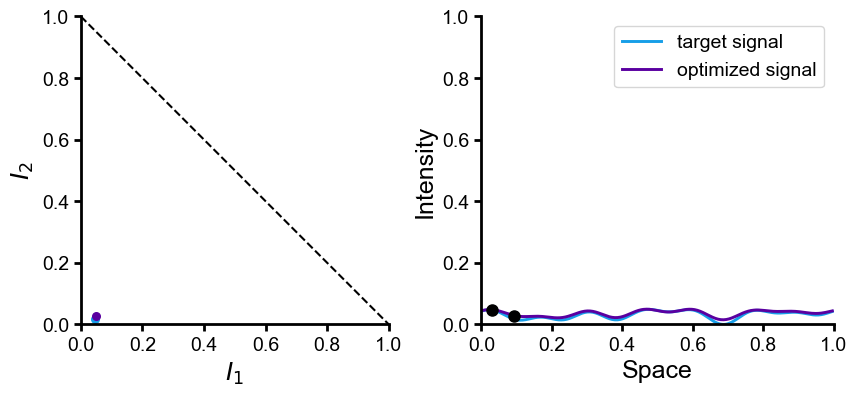

In [5]:

# generate a delta function target signal (cant be achieved because of bandlimit)
use_sampling_indices = False
sampling_indices = (0, 1)
norm_energy = True
# num_nyquist_samples = NUM_NYQUIST_SAMPLES
# num_nyquist_samples = NUM_NYQUIST_SAMPLES // 2
num_nyquist_samples = 16

delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
input_signal = delta_function

# target_signal = onp.zeros_like(generate_concentrated_signal(sampling_indices, num_nyquist_samples=num_nyquist_samples))
# # target_signal[sampling_indices[0]] = 1
# target_signal[sampling_indices[0]] = 0.5
# target_signal[sampling_indices[1]] = 0.5
# target_signal = np.array(target_signal)
# # target_signal = bandlimited_nonnegative_signal(target_signal)

target_signal = generate_random_bandlimited_signal(num_nyquist_samples=num_nyquist_samples, seed=1234456)
# print(target_signal.sum())

# nyquist_samples = onp.zeros(num_nyquist_samples)
# nyquist_samples[0] = 1
# nyquist_samples[1] = 0.5
# nyquist_samples[2:] = 0
# target_signal = bandlimited_nonnegative_signal(nyquist_samples, num_nyquist_samples=num_nyquist_samples)

initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal(num_nyquist_samples=num_nyquist_samples), 
                                                num_nyquist_samples=num_nyquist_samples)

loss_fn = make_convolutional_forward_model_and_target_signal_MSE_loss_fn(input_signal, target_signal, 
                                                       sampling_indices=sampling_indices if use_sampling_indices else None)
optimized_params = run_optimzation(loss_fn, lambda x : signal_prox_fn(x, num_nyquist_samples=num_nyquist_samples), 
                         params_from_signal(initial_kernel, num_nyquist_samples=num_nyquist_samples), learning_rate=1e-3, verbose=True)

optimized_kernel = signal_from_params(optimized_params, num_nyquist_samples=num_nyquist_samples)

# make the convolutional encoder from the optimized kernel
optimized_conv_mat = make_convolutional_encoder(optimized_kernel, num_nyquist_samples=num_nyquist_samples)
initial_conv_mat = make_convolutional_encoder(initial_kernel, num_nyquist_samples=num_nyquist_samples)
optimized_signal = optimized_conv_mat @ input_signal
initial_signal = initial_conv_mat @ input_signal

# plot target and optimized signal in intensity and spatial coordinates
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
plot_in_intensity_coordinates(ax[0], target_signal, label='target signal', sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax[0], optimized_signal, label='optimized signal', sample_point_indices=sampling_indices)

plot_in_spatial_coordinates(ax[1], target_signal, label='target signal', sample_point_indices=sampling_indices)
plot_in_spatial_coordinates(ax[1], optimized_signal, label='optimized signal', sample_point_indices=sampling_indices, show_samples=True)
ax[1].legend()

optimized_signal.sum()

## Make a grid of points to use as loss function targets

  0%|          | 0/34 [00:00<?, ?it/s]

initial loss 0.0042391694


  3%|▎         | 1/34 [00:14<07:42, 14.02s/it]

initial loss 0.0061751097


  6%|▌         | 2/34 [00:31<08:30, 15.94s/it]

initial loss 0.04892738


  9%|▉         | 3/34 [00:53<09:46, 18.93s/it]

initial loss 0.13249598


 12%|█▏        | 4/34 [01:40<14:59, 29.98s/it]

initial loss 0.2568809


 15%|█▍        | 5/34 [02:41<19:49, 41.00s/it]

initial loss 0.42208213


 18%|█▊        | 6/34 [03:47<23:08, 49.59s/it]

initial loss 0.6280998


 21%|██        | 7/34 [04:51<24:28, 54.41s/it]

initial loss 0.8749336


 24%|██▎       | 8/34 [05:55<24:54, 57.47s/it]

initial loss 0.022449251


 26%|██▋       | 9/34 [06:20<19:39, 47.17s/it]

initial loss 0.024385192


 29%|██▉       | 10/34 [06:34<14:44, 36.85s/it]

initial loss 0.067137465


 32%|███▏      | 11/34 [06:53<12:06, 31.60s/it]

initial loss 0.15070607


 35%|███▌      | 12/34 [07:13<10:15, 27.98s/it]

initial loss 0.275091


 38%|███▊      | 13/34 [08:04<12:16, 35.07s/it]

initial loss 0.4402922


 41%|████      | 14/34 [09:09<14:38, 43.93s/it]

initial loss 0.08147567


 44%|████▍     | 15/34 [09:48<13:24, 42.37s/it]

initial loss 0.083411604


 47%|████▋     | 16/34 [10:07<10:39, 35.54s/it]

initial loss 0.12616387


 50%|█████     | 17/34 [10:21<08:12, 28.96s/it]

initial loss 0.20973247


 53%|█████▎    | 18/34 [10:40<06:58, 26.13s/it]

initial loss 0.3341174


 56%|█████▌    | 19/34 [11:32<08:26, 33.76s/it]

initial loss 0.49931863


 59%|█████▉    | 20/34 [12:36<10:01, 42.96s/it]

initial loss 0.18131842


 62%|██████▏   | 21/34 [12:55<07:43, 35.68s/it]

initial loss 0.18325436


 65%|██████▍   | 22/34 [13:21<06:34, 32.87s/it]

initial loss 0.22600663


 68%|██████▊   | 23/34 [13:41<05:17, 28.89s/it]

initial loss 0.30957523


 71%|███████   | 24/34 [14:26<05:38, 33.85s/it]

initial loss 0.43396014


 74%|███████▎  | 25/34 [15:31<06:27, 43.04s/it]

initial loss 0.32197747


 76%|███████▋  | 26/34 [16:03<05:16, 39.61s/it]

initial loss 0.3239134


 79%|███████▉  | 27/34 [16:54<05:02, 43.23s/it]

initial loss 0.36666566


 82%|████████▏ | 28/34 [17:54<04:48, 48.05s/it]

initial loss 0.4502343


 85%|████████▌ | 29/34 [18:59<04:26, 53.36s/it]

initial loss 0.50345284


 88%|████████▊ | 30/34 [20:05<03:48, 57.18s/it]

initial loss 0.5053888


 91%|█████████ | 31/34 [21:11<02:59, 59.81s/it]

initial loss 0.54814106


 94%|█████████▍| 32/34 [22:17<02:03, 61.70s/it]

initial loss 0.72574466


 97%|█████████▋| 33/34 [23:24<01:03, 63.20s/it]

initial loss 0.98885256


100%|██████████| 34/34 [24:30<00:00, 43.26s/it]

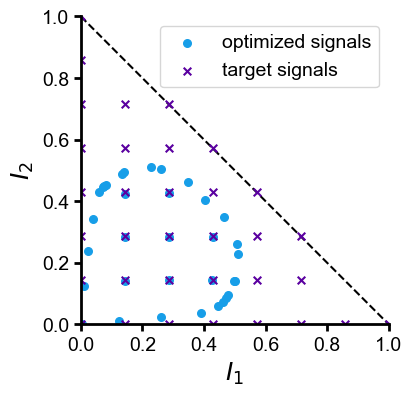

In [6]:
num_nyquist_samples = NUM_NYQUIST_SAMPLES
sampling_indices = (0, 1)
num_grid_points = 8
delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
object = delta_function

target_signals = make_intensity_coordinate_sampling_grid(sampling_indices, sample_n=num_grid_points, num_nyquist_samples=num_nyquist_samples)
# target_signals = np.array([target_signal])
optimized_kernels, output_signals = optimize_towards_target_signals(target_signals, object,
                                                                    sampling_indices=sampling_indices,
                                                                    verbose=True)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_in_intensity_coordinates(ax, output_signals, label='optimized signals',  sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax, target_signals, label='target signals',  marker='x',  sample_point_indices=sampling_indices)
ax.legend()

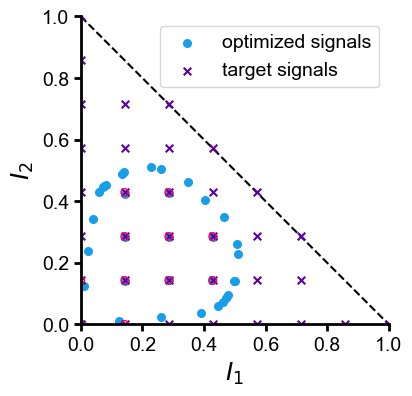

In [8]:
# compute L2 distance between target and output signals
dist = np.sqrt(np.sum((target_signals[:, sampling_indices] - output_signals[:, sampling_indices]) ** 2, axis=1))
threshold = 0.03

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
plot_in_intensity_coordinates(ax, output_signals, label='optimized signals',  sample_point_indices=sampling_indices)
plot_in_intensity_coordinates(ax, target_signals, label='target signals',  marker='x',  sample_point_indices=sampling_indices)

# plot open circles on all the ones that have a distance below a threshold
plot_in_intensity_coordinates(ax, target_signals[dist < threshold], 
                               sample_point_indices=sampling_indices, marker='o', color='none', edgecolor=get_color_cycle()[2])
ax.legend()

## Plot the randomly generated signals

100%|██████████| 20000/20000 [00:19<00:00, 1009.84it/s]


num positive targets: 6360
num negative targets: 13640


[(0.0, 1.0), (0.0, 1.0)]

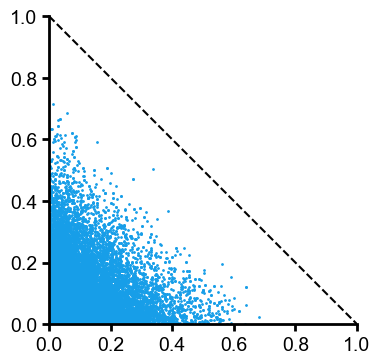

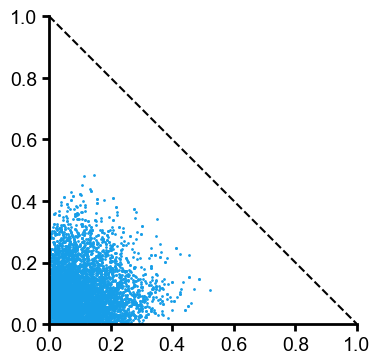

In [20]:
num_nyquist_samples = 8

# load  samples
l1_ball_samples = np.load(".cache/{}_dimensional_random_L1_ball_samples.npy".format(num_nyquist_samples), allow_pickle=True)
l1_ball_samples = np.array(l1_ball_samples)

l1_ball_samples = l1_ball_samples


# plot the samples
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.scatter(l1_ball_samples[:, 0], l1_ball_samples[:, 1], s=1)
# plot dashed line for the L1 ball
ax.plot(np.linspace(0, 1, 100), 1 - np.abs(np.linspace(0, 1, 100)), '--', color='k')
# square axes
ax.set_aspect('equal', 'box')
clear_spines(ax)
ax.set(xlim=(0, 1), ylim=(0, 1))

positive_targets = []
negative_targets = []
positive_indices = []
negative_indices = []
for i, t in tqdm(enumerate(l1_ball_samples), total=l1_ball_samples.shape[0]):
    upsampled = upsample_signal(t, num_nyquist_samples=num_nyquist_samples)
    if upsampled.min() < 0:
        negative_targets.append(t)
        negative_indices.append(i)
    else:
        positive_targets.append(t)
        positive_indices.append(i)

# print num of each
print('num positive targets: {}'.format(len(positive_targets)))
print('num negative targets: {}'.format(len(negative_targets)))

# now scatter only the positive targets
positive_targets = np.array(positive_targets)
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.scatter(positive_targets[:, 0], positive_targets[:, 1], s=1)
# plot dashed line for the L1 ball
ax.plot(np.linspace(0, 1, 100), 1 - np.abs(np.linspace(0, 1, 100)), '--', color='k')
# square axes
ax.set_aspect('equal', 'box')
clear_spines(ax)
ax.set(xlim=(0, 1), ylim=(0, 1))

## Figure out tolerance by optimizing to random signals

In [33]:
delta_function = onp.zeros(OBJECT_LENGTH)
delta_function[delta_function.size // 2] = 1
input_signal = delta_function

target_signals = l1_ball_samples[:50]

optimized_kernels, output_signals = optimize_towards_target_signals(target_signals, input_signal, verbose=True)


  0%|          | 0/50 [00:00<?, ?it/s]

initial loss 0.03455104


  2%|▏         | 1/50 [00:15<12:28, 15.28s/it]

initial loss 0.17116752


  4%|▍         | 2/50 [00:28<11:26, 14.31s/it]

initial loss 0.25758666


  6%|▌         | 3/50 [00:49<13:24, 17.11s/it]

initial loss 0.09384161


  8%|▊         | 4/50 [01:10<14:21, 18.72s/it]

initial loss 0.24117446


 10%|█         | 5/50 [01:26<13:16, 17.70s/it]

initial loss 0.1262258


 12%|█▏        | 6/50 [01:47<13:52, 18.91s/it]

initial loss 0.100790516


 14%|█▍        | 7/50 [02:07<13:44, 19.18s/it]

initial loss 0.08308384


 16%|█▌        | 8/50 [02:28<13:55, 19.90s/it]

initial loss 0.16136083


 18%|█▊        | 9/50 [02:50<13:53, 20.34s/it]

initial loss 0.19251972


 20%|██        | 10/50 [03:08<13:10, 19.77s/it]

initial loss 0.121153116


 22%|██▏       | 11/50 [03:36<14:23, 22.13s/it]

initial loss 0.18892792


 24%|██▍       | 12/50 [03:51<12:45, 20.15s/it]

initial loss 0.3489879


 26%|██▌       | 13/50 [04:08<11:41, 18.96s/it]

initial loss 0.05740449


 28%|██▊       | 14/50 [04:25<11:01, 18.38s/it]

initial loss 0.22077987


 30%|███       | 15/50 [04:41<10:25, 17.87s/it]

initial loss 0.08314113


 32%|███▏      | 16/50 [05:01<10:24, 18.37s/it]

initial loss 0.16152345


 34%|███▍      | 17/50 [05:20<10:19, 18.77s/it]

initial loss 0.19928077


 36%|███▌      | 18/50 [05:38<09:44, 18.27s/it]

initial loss 0.10306833


 38%|███▊      | 19/50 [05:55<09:17, 17.99s/it]

initial loss 0.060482353


 40%|████      | 20/50 [06:17<09:34, 19.14s/it]

initial loss 0.16479997


 42%|████▏     | 21/50 [06:38<09:33, 19.79s/it]

initial loss 0.076889455


 44%|████▍     | 22/50 [06:59<09:20, 20.00s/it]

initial loss 0.29221696


 46%|████▌     | 23/50 [07:15<08:33, 19.02s/it]

initial loss 0.23880947


 48%|████▊     | 24/50 [07:35<08:19, 19.19s/it]

initial loss 0.51014566


 50%|█████     | 25/50 [07:51<07:38, 18.33s/it]

initial loss 0.1779693


 52%|█████▏    | 26/50 [08:08<07:08, 17.86s/it]

initial loss 0.32946914


 54%|█████▍    | 27/50 [08:23<06:30, 16.99s/it]

initial loss 0.40256754


 56%|█████▌    | 28/50 [08:39<06:07, 16.73s/it]

initial loss 0.1932256


 58%|█████▊    | 29/50 [08:58<06:02, 17.28s/it]

initial loss 0.20204286


 60%|██████    | 30/50 [09:16<05:50, 17.51s/it]

initial loss 0.19875571


 62%|██████▏   | 31/50 [09:35<05:42, 18.05s/it]

initial loss 0.42939344


 64%|██████▍   | 32/50 [09:54<05:27, 18.20s/it]

initial loss 0.2466488


 66%|██████▌   | 33/50 [10:12<05:09, 18.20s/it]

initial loss 0.15781009


 68%|██████▊   | 34/50 [10:27<04:35, 17.24s/it]

initial loss 0.3183227


 70%|███████   | 35/50 [10:39<03:56, 15.79s/it]

initial loss 0.070539504


 72%|███████▏  | 36/50 [10:51<03:25, 14.66s/it]

initial loss 0.08558504


 74%|███████▍  | 37/50 [11:05<03:06, 14.36s/it]

initial loss 0.17817429


 76%|███████▌  | 38/50 [11:17<02:45, 13.82s/it]

initial loss 0.32406095


 78%|███████▊  | 39/50 [11:29<02:26, 13.29s/it]

initial loss 0.16039878


 80%|████████  | 40/50 [11:43<02:14, 13.43s/it]

initial loss 0.21646959


 82%|████████▏ | 41/50 [11:57<02:02, 13.61s/it]

initial loss 0.3341904


 84%|████████▍ | 42/50 [12:11<01:50, 13.78s/it]

initial loss 0.22342843


 86%|████████▌ | 43/50 [12:24<01:34, 13.50s/it]

initial loss 0.09745444


 88%|████████▊ | 44/50 [12:37<01:19, 13.32s/it]

initial loss 0.5040722


 90%|█████████ | 45/50 [12:47<01:01, 12.36s/it]

initial loss 0.21876049


 92%|█████████▏| 46/50 [13:00<00:49, 12.39s/it]

initial loss 0.32727757


 94%|█████████▍| 47/50 [13:12<00:36, 12.31s/it]

initial loss 0.30541605


 96%|█████████▌| 48/50 [13:24<00:24, 12.23s/it]

initial loss 0.12118158


 98%|█████████▊| 49/50 [13:35<00:11, 11.84s/it]

initial loss 0.04434132


100%|██████████| 50/50 [13:46<00:00, 16.54s/it]

num positive targets: 14
num negative targets: 36


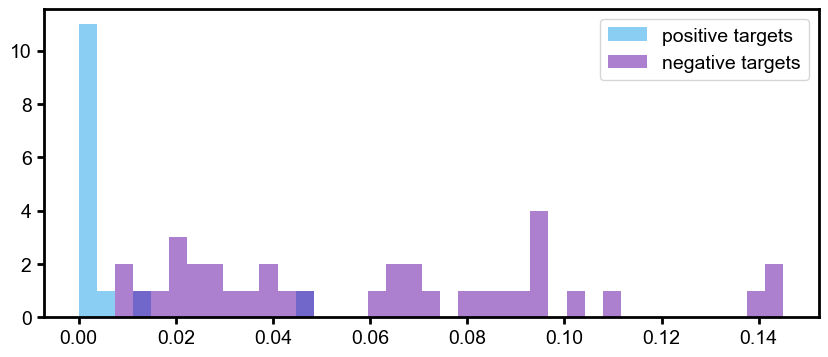

In [41]:

# plot overlapping histograms of the distances of the positive and negative targets

dist = onp.sqrt(np.sum((target_signals - output_signals) ** 2, axis=1))
bins = np.linspace(0, dist.max(), 40)
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(dist[positive_indices], bins=bins, alpha=0.5, label='positive targets')
ax.hist(dist[negative_indices], bins=bins, alpha=0.5, label='negative targets')
ax.legend()

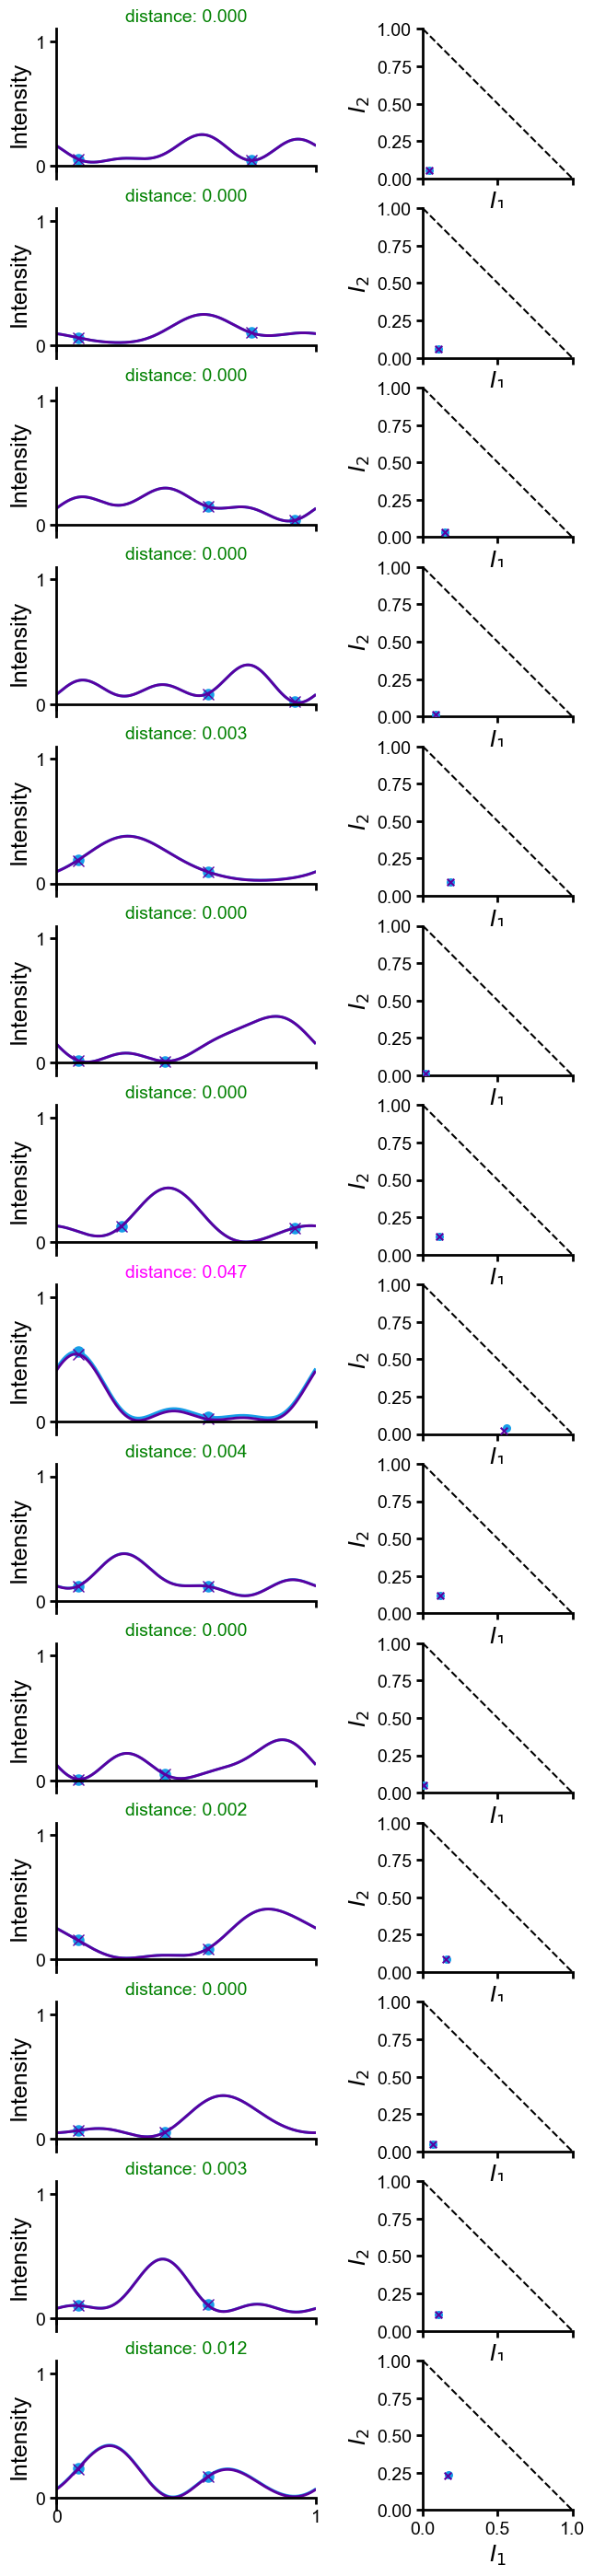

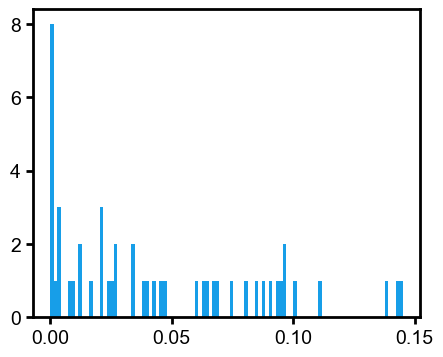

In [39]:
threshold = 0.023

# compute L2 distance between target and output signals
dist = np.sqrt(np.sum((target_signals - output_signals) ** 2, axis=1))

indices = positive_indices

# indices = onp.random.choice(np.arange(target_signals.shape[0]), size=9, replace=False)
# indices = np.argsort(np.abs(dist - threshold))[:9]


# make a 2x6 grid with spatial plots on top and intensity plots on bottom
fig, ax = plt.subplots(len(indices), 2, figsize=(8, 2.5 * len(indices)), sharex='col', sharey='col')
for i, (ax1, ax2) in enumerate(zip(ax[:, 0], ax[:, 1])):
    output_signal = output_signals[indices[i]]
    target_signal = target_signals[indices[i]]
    # find sampling indices, as the two where they differ the most
    sampling_indices = np.argsort(np.abs(output_signal - target_signal))[-2:]

    plot_in_spatial_coordinates(ax1, output_signal, label='optimized signals', sample_point_indices=sampling_indices,
                                color_samples=True, show_samples=True, xlabel=None)
    plot_in_spatial_coordinates(ax1, target_signal, label='target signals', marker='x', color_samples=True,
                                sample_point_indices=sampling_indices, show_samples=True, xlabel=None)
    plot_in_intensity_coordinates(ax2, output_signal, label='optimized signals', sample_point_indices=sampling_indices)
    plot_in_intensity_coordinates(ax2, target_signal, label='target signals', marker='x', 
                                   sample_point_indices=sampling_indices)

    ax1.set(ylim=(-0.1, 1.1), yticks=[0, 1], xticks=[0, 1])
    ax1.spines['bottom'].set_position(('data', 0))

    dist_for_this = dist[indices[i]]
    # ax1.set_title(f'distance: {dist[random_indices[i]]:.2f}')
    # make title green if distance is below threshold
    if dist_for_this < threshold:
        ax1.set_title(f'distance: {dist_for_this:.3f}', color='green')
    else:
        ax1.set_title(f'distance: {dist_for_this:.3f}', color='magenta')
    
# plot hist of distances
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
_ = ax.hist(dist, bins=100)

## Compare entropy to uniform entropy

In [23]:
N_objects = 2000
noise_sigma = 1e-3
N_objects_to_plot = 1
N_signals_to_plot = 6


erasure_mask = onp.ones(NUM_NYQUIST_SAMPLES)
# erasure_mask[erasure_mask.size // 4:] = 0
erasure_mask = np.array(erasure_mask, dtype=bool)


objects_fn = lambda : np.array([sample_amplitude_object('delta', num_deltas=1) for i in range(N_objects)])

objects = objects_fn()


initial_kernel = bandlimited_nonnegative_signal(nyquist_samples=generate_random_bandlimited_signal())

initial_params = np.concatenate(real_imag_params_from_signal(initial_kernel))

loss_fn = make_convolutional_forward_model_with_mi_loss_and_erasure(objects, erasure_mask, noise_sigma)
optimized_params = run_optimzation(loss_fn, signal_prox_fn, 
                         initial_params,
                           learning_rate=1e-2, learning_rate_decay=0.999,
                           verbose=True,
                         loss_improvement_patience=2000, max_epochs=5000, key=jax.random.PRNGKey(0))
optimized_loss = loss_fn(optimized_params, key=jax.random.PRNGKey(0))

test_objects = objects_fn()
output_signals = conv_forward_model(optimized_params, test_objects)
diff_ent = compute_gaussian_differential_entropy(output_signals, ev_threshold=1e-3, average_values=False)

initial loss -3.4727716


TypeError: <lambda>() takes 0 positional arguments but 1 was given

In [28]:
test_objects = objects_fn()
output_signals = conv_forward_model(optimized_params, test_objects)
diff_ent = compute_gaussian_differential_entropy(output_signals, ev_threshold=1e-3, average_values=False)
diff_ent.sum()

Array(-40.669167, dtype=float32)